In [1]:
from matplotlib.pyplot import figure, rcParams
from conf_matplotlib import conf_matplotlib_oscuro
conf_matplotlib_oscuro()

In [2]:
from datetime import datetime, timedelta

In [3]:
from numpy import pi, degrees, radians, linspace, array

In [4]:
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, ICRS
#from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
#from astropy.coordinates import GeocentricTrueEcliptic
from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

In [5]:
from poliastro.twobody.propagation import propagate, cowell
#from poliastro.twobody.thrust import change_inc_ecc
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.bodies import Earth, Moon, Sun
from poliastro.util import norm
from poliastro.ephem import build_ephem_interpolant

In [6]:
from poliastro.plotting import OrbitPlotter2D, OrbitPlotter3D, StaticOrbitPlotter
from poliastro.core.perturbations import J2_perturbation, J3_perturbation
from poliastro.core.perturbations import third_body, radiation_pressure
from poliastro.core.util import jit

In [7]:
ΔV = 0.035078249 * u.m/u.s
thruster_secs = 26.88 * u.s
duty_cycle = 0.112 * u.one
thruster_eff = 1 * u.one

duration = thruster_secs / duty_cycle
δv = ΔV/int(duration.value)

thruster_vec = [1,0,0]*δv

EWSK0398 = [Maneuver((duty_cycle*u.s, thruster_vec)) for i in range(int(duration.value))]

In [8]:
epoch = Time(2000, format='jyear') + TimeDelta(638594520*u.s)
r = [21688591.8, -36154596.3, -22139.6363]*u.m
v = [2636.61379, 1582.13661, -5.16579754]*u.m/u.s

s0 = Orbit.from_vectors(Earth, r=r, v=v, epoch=Time(epoch, format="jyear"))

In [9]:
mnvr_epoch = datetime(2020, 3, 27, 16, 37, 5)
ff_time = (mnvr_epoch - epoch.datetime).seconds
downtime = 1 - duty_cycle.value

In [10]:
s1 = s0.propagate(ff_time*u.s, method=cowell, ad=J2_perturbation,
                  J2=Earth.J2.value, R=Earth.R.to(u.km).value)

In [11]:
sf = s1

for i in range(int(duration.value)):
    thruster_vec = (sf.v/norm(sf.v)).value*δv
    mnvr = Maneuver((duty_cycle*u.s, thruster_vec))
    sf = sf.apply_maneuver(mnvr)
    sf = sf.propagate(downtime*u.s, method=cowell, ad=J2_perturbation,
                      J2=Earth.J2.value, R=Earth.R.to(u.km).value)

#for pulse in EWSK0398:
#    sf = sf.apply_maneuver(pulse)
#    sf = sf.propagate(downtime*u.s, method=cowell, ad=J2_perturbation,
#                      J2=Earth.J2.value, R=Earth.R.to(u.km).value)
    
s1 = s1.propagate((sf.epoch.datetime - s1.epoch.datetime).seconds*u.s,
                  method=cowell, ad=J2_perturbation, J2=Earth.J2.value,
                  R=Earth.R.to(u.km).value)

In [12]:
ts = TimeDelta(linspace(1*u.s, 4*u.week, 1000))

In [13]:
solar_system_ephemeris.set("de432s")

inicio = (s1.epoch).jd*u.day
final  = (s1.epoch + ts[-1]).jd*u.day
moon_r = build_ephem_interpolant(Moon, 28 * u.day, (inicio, final))
sun_r  = build_ephem_interpolant(Sun, 365 * u.day, (inicio, final))
#moon_r, sun_r = 0, 0
#moon_r = 0


def perturbaciones(t0, state, k,
                   J2, J3, R,
                   C_R, A, m, Wdivc_s, star,
                   k_third_moon, third_body_moon,
                   k_third_sun, third_body_sun):
    
    pert1 = J2_perturbation(t0=t0, state=state, k=k, J2=J2, R=R)
    pert2 = J3_perturbation(t0=t0, state=state, k=k, J3=J3, R=R)
    pert3 = radiation_pressure(t0=t0, state=state, k=k, R=R, C_R = C_R,
                               A=A, m=m, Wdivc_s=Wdivc_s, star=star)
    pert4 = third_body(t0=t0, state=state, k=k, k_third=k_third_moon,
                       third_body=third_body_moon)
    pert5 = third_body(t0=t0, state=state, k=k, k_third=k_third_sun,
                       third_body=third_body_sun)
    #print(pert1)
    return pert1 + pert2 + pert3.value + pert4 + pert5

In [14]:
cart_coord_1 = propagate(s1, ts, method=cowell, ad=perturbaciones,
                         J2=Earth.J2.value, J3=Earth.J3.value,
                         R=Earth.R.to(u.km).value,
                         C_R=1.5*u.one, A=0.1*u.one, m=1000*u.kg,
                         Wdivc_s=Sun.Wdivc, star=sun_r,
                         k_third_moon=Moon.k.to(u.km ** 3 / u.s ** 2).value,
                         third_body_moon=moon_r,
                         k_third_sun=Sun.k.to(u.km ** 3 / u.s ** 2).value,
                         third_body_sun=sun_r)

cart_coord_f = propagate(sf, ts, method=cowell, ad=perturbaciones,
                         J2=Earth.J2.value, J3=Earth.J3.value,
                         R=Earth.R.to(u.km).value,
                         C_R=1.5*u.one, A=0.1*u.one, m=1000*u.kg,
                         Wdivc_s=Sun.Wdivc, star=sun_r,
                         k_third_moon=Moon.k.to(u.km ** 3 / u.s ** 2).value,
                         third_body_moon=moon_r,
                         k_third_sun=Sun.k.to(u.km ** 3 / u.s ** 2).value,
                         third_body_sun=sun_r)

In [15]:
coord_1 = [SkyCoord(coord).geocentrictrueecliptic for coord in cart_coord_1]
coord_f = [SkyCoord(coord).geocentrictrueecliptic for coord in cart_coord_f]

In [16]:
lons_1 = [coord.lon.value for coord in coord_1]
lats_1 = [coord.lat.value for coord in coord_1]

lons_f = [coord.lon.value for coord in coord_f]
lats_f = [coord.lat.value for coord in coord_f]

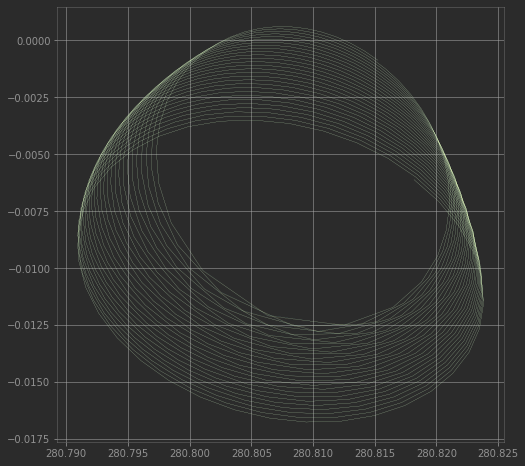

In [17]:
fig = figure(figsize=(8,8))
ax = fig.gca()
ax.plot(lons_1, lats_1, lw=0.1)
ax.plot(lons_f, lats_f, lw=0.1)
#ax.set_xlim(280.7, 280.9)
#ax.set_ylim(-0.1, 0.1);

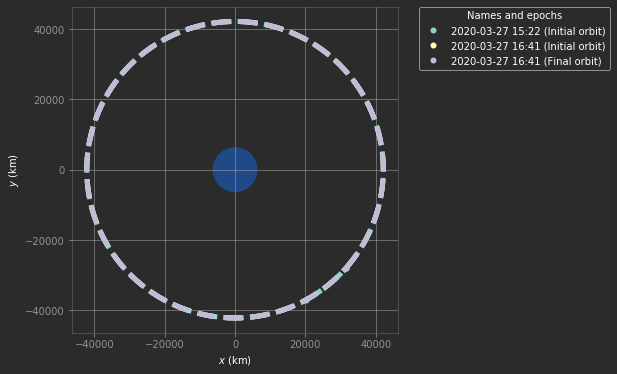

In [18]:
op = StaticOrbitPlotter()

op.plot(s0, label="Initial orbit")
op.plot(s1, label="Initial orbit")
op.plot(sf, label="Final orbit");

In [19]:
s0.classical()

(<Quantity 42163.99697591 km>,
 <Quantity 0.0001488>,
 <Quantity 0.10085322 deg>,
 <Quantity 103.6017778 deg>,
 <Quantity 258.88231762 deg>,
 <Quantity -61.52516827 deg>)

In [20]:
s1.classical()

(<Quantity 42163.997106 km>,
 <Quantity 0.00015903>,
 <Quantity 0.10085218 deg>,
 <Quantity 103.60145988 deg>,
 <Quantity 261.74729601 deg>,
 <Quantity -44.56106718 deg>)

In [21]:
sf.classical()

(<Quantity 42164.95932194 km>,
 <Quantity 0.00017585>,
 <Quantity 0.10085219 deg>,
 <Quantity 103.60146286 deg>,
 <Quantity 256.46067442 deg>,
 <Quantity -39.27444283 deg>)

In [ ]:
op = OrbitPlotter3D(dark=True)

op.plot(s1, label="Initial orbit")
op.plot(sf, label="Initial orbit")

In [93]:
lat_cc, long_cc = 19.3686347, -99.0619109

In [94]:
cc = EarthLocation(lat=lat_cc*u.deg, lon=long_cc*u.deg, height=2250*u.m)

In [95]:
coord_1 = [SkyCoord(coord) for coord in cart_coord_1]
coord_f = [SkyCoord(coord) for coord in cart_coord_f]

In [96]:
obs_1 = [coord.transform_to(AltAz(obstime=s1.epoch+t, location=cc)) for coord, t in zip(*[coord_1, ts])]
obs_f = [coord.transform_to(AltAz(obstime=s1.epoch+t, location=cc)) for coord, t in zip(*[coord_f, ts])]

In [97]:
alts_1 = [obs.alt.value for obs in obs_1]
azs_1  = [obs.az.value  for obs in obs_1]

alts_f = [obs.alt.value for obs in obs_f]
azs_f  = [obs.az.value  for obs in obs_f]

In [81]:
360 - 114.8

245.2

In [41]:
xs = [coord.x.value for coord in cart_coord_1]
ys = [coord.y.value for coord in cart_coord_1]
zs = [coord.z.value for coord in cart_coord_1]

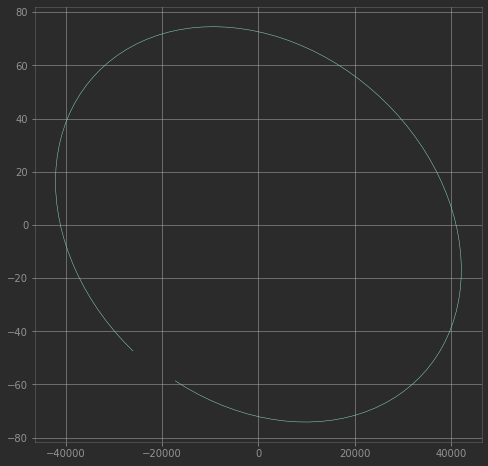

In [44]:
fig = figure(figsize=(8,8))
ax = fig.gca()
ax.plot(ys, zs, lw=0.5)
#ax.plot(azs_f, alts_f, lw=0.5)

In [40]:
from skyfield.api import Topos, load
from skyfield.positionlib import ICRF
planets = load("de421.bsp")
earth = planets["earth"]
mars = planets["mars"]

ts = load.timescale()

coords_1 = [ICRF(coord) for coord in cart_coord_1]
coords_f = [ICRF(coord) for coord in cart_coord_f]

In [33]:
cc = earth + Topos(lat_cc, long_cc)

In [44]:
astro = cc.at(ts.now()).observe(coords_1[0])

AttributeError: 'ICRF' object has no attribute '_observe_from_bcrs'

In [35]:
alt, az, dis = astro.apparent().altaz()

In [36]:
alt

<Angle 46deg 01' 22.5">

In [24]:
cart_coord_1[0]

<CartesianRepresentation (x, y, z) in km
    (38463.06201068, -17259.63353625, -58.65579276)
 (has differentials w.r.t.: 's')>

In [38]:
uno = cc.at(ts.now())

In [39]:
uno.observe?

Signature: uno.observe(body)
Docstring:
Compute the `Astrometric` position of a body from this location.

To compute the body's astrometric position, it is first asked
for its position at the time `t` of this position itself.  The
distance to the body is then divided by the speed of light to
find how long it takes its light to arrive.  Finally, the light
travel time is subtracted from `t` and the body is asked for a
series of increasingly exact positions to learn where it was
when it emitted the light that is now reaching this position.

>>> earth.at(t).observe(mars)
<Astrometric ICRS position and velocity at date t center=399 target=499>
File:      ~/miniconda3/lib/python3.6/site-packages/skyfield/positionlib.py
Type:      method


In [18]:
def dt_long(time):
    from numpy import pi, degrees
    τ = 2*pi
    hora = time.hour
    minuto = time.minute
    segundo = time.second
    l_hor = τ*hora/24
    l_min = τ*minuto/60/24
    l_seg = τ*segundo/60/60/24
    return degrees(l_hor + l_min + l_seg)

In [19]:
efem_1 = [[coord, s1.epoch + delta] for coord, delta in zip(*[cart_coord_1, ts])]
GCTE_coord_1 = [GeocentricTrueEcliptic(efem[0], obstime=efem[1]) for efem in efem_1]

efem_f = [[coord, sf.epoch + delta] for coord, delta in zip(*[cart_coord_f, ts])]
GCTE_coord_f = [GeocentricTrueEcliptic(efem[0], obstime=efem[1]) for efem in efem_f]

longs_1 = [(coord.lon.value - dt_long((s1.epoch + t).datetime))%-360 for coord, t in zip(*[GCTE_coord_1, ts])]
lats_1  = [coord.lat.value for coord in GCTE_coord_1]

longs_f = [(coord.lon.value  - dt_long((s1.epoch + t).datetime))%-360 for coord, t in zip(*[GCTE_coord_f, ts])]
lats_f  = [coord.lat.value for coord in GCTE_coord_f]

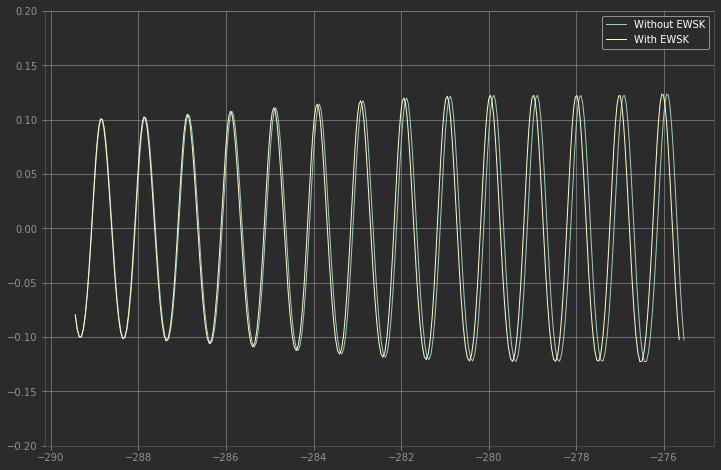

In [20]:
fig = figure(figsize=(12,8))
ax = fig.gca()
ax.plot(longs_1, lats_1, lw=1, label="Without EWSK")
ax.plot(longs_f, lats_f, lw=1, label="With EWSK")
#ax.plot(longs_1[0], lats_1[0], "*", lw=1, label="TF")
#ax.plot(longs_1[-1], lats_1[-1], ".", lw=1, label="TF + 2 Weeks")
ax.set_ylim(-0.2, 0.2)
ax.legend();

In [55]:
coords_1 = []
coords_f = []

for i in range(24*7*2):
    s1 = s1.propagate(3600*u.s, method=cowell, ad=J2_perturbation,
                      J2=Earth.J2.value, R=Earth.R.to(u.km).value)
    coords_1.append([s1.represent_as(SphericalRepresentation), s1.epoch.datetime])
    
    sf = sf.propagate(3600*u.s, method=cowell, ad=J2_perturbation,
                      J2=Earth.J2.value, R=Earth.R.to(u.km).value)
    coords_f.append([sf.represent_as(SphericalRepresentation), sf.epoch.datetime])

In [57]:
τ = 2*pi
efem_prop_1 = [[coord.lon, coord.lat, time] for coord, time in coords_0]
efem_prop_f = [[coord.lon, coord.lat, time] for coord, time in coords_f]

longs_1, lats_1 = [], []
for lon, lat, tiempo in efem_prop_1:
    longs_1.append(degrees((lon.value - dt_long(tiempo))%-τ))
    lats_1.append(degrees(lat.value))

longs_f, lats_f = [], []
for lon, lat, tiempo in efem_prop_f:
    longs_f.append(degrees((lon.value - dt_long(tiempo))%-τ))
    lats_f.append(degrees(lat.value))

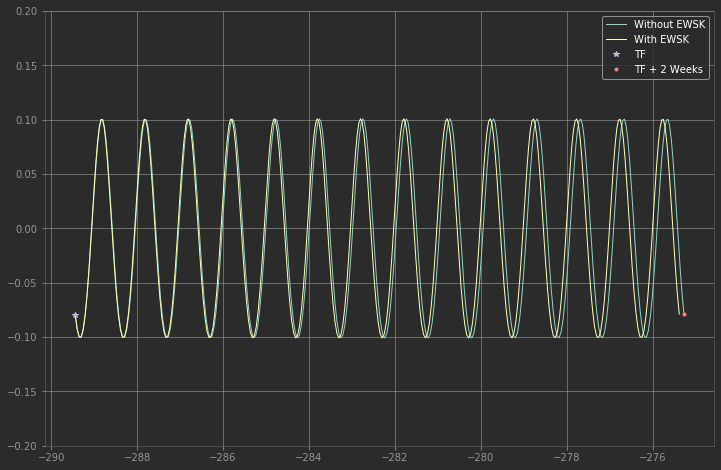

In [65]:
fig = figure(figsize=(12,8))
ax = fig.gca()
ax.plot(longs_1, lats_1, lw=1, label="Without EWSK")
ax.plot(longs_f, lats_f, lw=1, label="With EWSK")
ax.plot(longs_1[0], lats_1[0], "*", lw=1, label="TF")
ax.plot(longs_1[-1], lats_1[-1], ".", lw=1, label="TF + 2 Weeks")
ax.set_ylim(-0.2, 0.2)
ax.legend();